# Plot calibrated MVBS data and PCP output

In this notebook we plot the original MVBS data as well as the low-rank and the sparse components. 
These are Fig. 2 and Fig. S1 in the paper.

**Fig. 2.** The original calibrated multi-frequency mean volume backscattering strength (MVBS) data and the PCP low-rank component.

**Fig. S1.** The PCP sparse component for two different time scales.

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
MVBS_path = './data'
MVBS_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected.nc'

In [3]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

In [4]:
MVBS_PCP_path = './data'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [5]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
MVBS_rpca

<xarray.Dataset>
Dimensions:    (date: 62, depth: 37, frequency: 3, hour: 144)
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83
Data variables:
    low_rank   (date, frequency, depth, hour) float64 ...
    sparse     (date, frequency, depth, hour) float64 ...

In [6]:
MVBS_rpca['low_rank'].values.shape

(62, 3, 37, 144)

In [7]:
MVBS_rpca_L = np.moveaxis(MVBS_rpca['low_rank'].values,[0,1,2],[2,0,1]).reshape((3,37,-1))
MVBS_rpca_S = np.moveaxis(MVBS_rpca['sparse'].values,[0,1,2],[2,0,1]).reshape((3,37,-1))

Create dataArray for plotting echograms with the right labels:

In [8]:
ds_MVBS_raw = xr.Dataset({'MVBS': (['depth','ping_time','frequency'], 
                                   MVBS['MVBS'].isel(range_bin=slice(1,38)))},
                     coords={'frequency': MVBS['frequency'].values,
                             'depth': MVBS_rpca['depth'].values,
                             'ping_time': MVBS['ping_time']})

In [9]:
ds_rpca = xr.Dataset({'low_rank': (['frequency','depth','ping_time'], MVBS_rpca_L),
                      'sparse': (['frequency','depth','ping_time'], MVBS_rpca_S)},
                     coords={'frequency': MVBS_rpca['frequency'].values,
                             'depth': MVBS_rpca['depth'].values[::-1],
                             'ping_time': MVBS['ping_time']})

## Fig. 2. MVBS data and PCP low-rank component

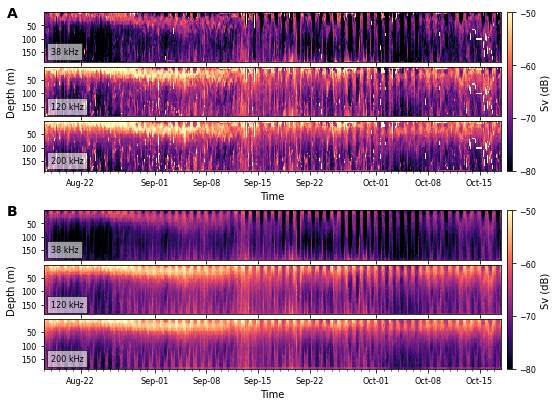

In [10]:
tick_label_size = 8
axis_label_size = 10
freq_label_size = 8
panel_label_size = 14
annotation_alpha = 0.6
vmin = -80
vmax = -50
cmap = 'magma'

fig = plt.figure(figsize=(7+1/16,5.5))
gs_top = fig.add_gridspec(3,1, bottom=0.55, top=0.95, left=0.05, right=0.95, hspace=0.1)
gs_bottom = fig.add_gridspec(3,1, bottom=0.05, top=0.45, left=0.05, right=0.95, hspace=0.1)

# Calibrated MVBS echogram
axx = []
for seq, key_val in enumerate(ds_MVBS_raw['MVBS'].groupby('frequency')):
    axx.append(fig.add_subplot(gs_top[seq, 0]))
    im = key_val[1].plot(ax=axx[-1], vmin=vmin, vmax=vmax, 
                         cmap=cmap, add_colorbar=False, yincrease=False)
    axx[-1].set_title('')
    axx[-1].tick_params(labelsize=tick_label_size)
    axx[-1].set_xlabel('')
    axx[-1].set_ylabel('')
    axx[-1].annotate('%d kHz'%(key_val[0]/1000), 
                   xy=(0.015,0.15), xycoords='axes fraction', 
                   fontsize=freq_label_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=annotation_alpha))
    axx[-1].set_xticklabels('')  # remove all xtick labels    
axx[2].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
axx[2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

axx[1].set_ylabel('Depth (m)', fontsize=axis_label_size)
axx[2].set_xlabel('Time', fontsize=axis_label_size)
plt.setp(axx[2].get_xticklabels(), rotation=0, horizontalalignment='center')

fig.text(x=-0.08,y=0.9,s='A',transform=axx[0].transAxes,   # Add panel label
                 fontsize=panel_label_size, fontweight='bold')

# PCP low-rank output
axx = []
for seq, key_val in enumerate(ds_rpca['low_rank'].groupby('frequency')):
    axx.append(fig.add_subplot(gs_bottom[seq, 0]))
    im = key_val[1].plot(ax=axx[-1], vmin=vmin, vmax=vmax, 
                         cmap=cmap, add_colorbar=False, yincrease=False)
    axx[-1].set_title('')
    axx[-1].tick_params(labelsize=tick_label_size)
    axx[-1].set_xlabel('')
    axx[-1].set_ylabel('')
    axx[-1].annotate('%d kHz'%(key_val[0]/1000), 
                   xy=(0.015,0.15), xycoords='axes fraction', 
                   fontsize=freq_label_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=annotation_alpha))
    axx[-1].set_xticklabels('')  # remove all xtick labels    
axx[2].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
axx[2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

axx[1].set_ylabel('Depth (m)', fontsize=axis_label_size)
axx[2].set_xlabel('Time', fontsize=axis_label_size)
plt.setp(axx[2].get_xticklabels(), rotation=0, horizontalalignment='center')

fig.text(x=-0.08,y=0.9,s='B',transform=axx[0].transAxes,  # Add panel label
                 fontsize=panel_label_size, fontweight='bold')


# Add colorbars
cbar = []
cbar_ax1 = fig.add_axes([0.96, 0.55, 0.01, 0.4])  # [left, bottom, width, height]
cbar.append(fig.colorbar(im, cax=cbar_ax1))
cbar_ax2 = fig.add_axes([0.96, 0.05, 0.01, 0.4])  # [left, bottom, width, height]
cbar.append(fig.colorbar(im, cax=cbar_ax2))
for cb in cbar:
    cb.set_ticks(np.arange(-80, -39, 10))
    cb.ax.tick_params(labelsize=tick_label_size) 
    cb.ax.get_yaxis().labelpad = 5
    cb.ax.set_ylabel('Sv (dB)', rotation=90, fontsize=axis_label_size)

plt.show()

fig.savefig(os.path.join('./figs','fig_echogram_raw_pcp.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)

**Fig. 2.** (A) Multi-frequency mean volume  backscattering  strength (MVBS) time  series collected concurrently by the echosounder. (B) Low-rank component resulting from Principal Component Pursuit (PCP) of the MVBS time series. The low-rank component is used in subsequent matrix and tensor decomposition analyses.

## Fig. S1. PCP sparse component

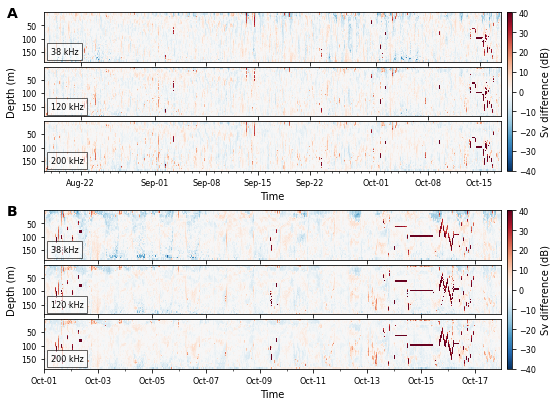

In [11]:
tick_label_size = 8
axis_label_size = 10
freq_label_size = 8
panel_label_size = 14
annotation_alpha = 0.6
vmin = -40
vmax = +40
cmap = 'RdBu_r'
start_time = '2015-10-01T00:00:00'
end_time = '2015-10-17T23:59:59'
# start_time = '2015-09-08T00:00:00'
# end_time = '2015-09-15T23:59:59'

fig = plt.figure(figsize=(7+1/16,5.5))
gs_top = fig.add_gridspec(3,1, bottom=0.55, top=0.95, left=0.05, right=0.95, hspace=0.1)
gs_bottom = fig.add_gridspec(3,1, bottom=0.05, top=0.45, left=0.05, right=0.95, hspace=0.1)

# PCP sparse output
axx = []
for seq, key_val in enumerate(ds_rpca['sparse'].groupby('frequency')):
    axx.append(fig.add_subplot(gs_top[seq, 0]))
    im = key_val[1].plot(ax=axx[-1], vmin=vmin, vmax=vmax, 
                         cmap=cmap, add_colorbar=False, yincrease=False)
    axx[-1].set_title('')
    axx[-1].tick_params(labelsize=tick_label_size)
    axx[-1].set_xlabel('')
    axx[-1].set_ylabel('')
    axx[-1].annotate('%d kHz'%(key_val[0]/1000), 
                   xy=(0.015,0.15), xycoords='axes fraction', 
                   fontsize=freq_label_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=annotation_alpha))
    axx[-1].set_xticklabels('')  # remove all xtick labels    
axx[2].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
axx[2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

axx[1].set_ylabel('Depth (m)', fontsize=axis_label_size)
axx[2].set_xlabel('Time', fontsize=axis_label_size)
plt.setp(axx[2].get_xticklabels(), rotation=0, horizontalalignment='center')

fig.text(x=-0.08,y=0.9,s='A',transform=axx[0].transAxes,   # Add panel label
                 fontsize=panel_label_size, fontweight='bold')

# PCP sparse output: zoomed in to October 1-17
axx = []
for seq, key_val in enumerate(ds_rpca['sparse'].sel(ping_time=slice(start_time, end_time)).groupby('frequency')):
    axx.append(fig.add_subplot(gs_bottom[seq, 0]))
    im = key_val[1].plot(ax=axx[-1], vmin=vmin, vmax=vmax, 
                         cmap=cmap, add_colorbar=False, yincrease=False)
    axx[-1].set_title('')
    axx[-1].tick_params(labelsize=tick_label_size)
    axx[-1].set_xlabel('')
    axx[-1].set_ylabel('')
    axx[-1].annotate('%d kHz'%(key_val[0]/1000), 
                   xy=(0.015,0.15), xycoords='axes fraction', 
                   fontsize=freq_label_size, color='k', 
                   bbox=dict(facecolor='w', edgecolor=None, alpha=annotation_alpha))
    axx[-1].set_xticklabels('')  # remove all xtick labels    
axx[2].xaxis.set_minor_locator(mdates.DayLocator(bymonthday=range(0,32,1)))
axx[2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

axx[1].set_ylabel('Depth (m)', fontsize=axis_label_size)
axx[2].set_xlabel('Time', fontsize=axis_label_size)
plt.setp(axx[2].get_xticklabels(), rotation=0, horizontalalignment='center')

fig.text(x=-0.08,y=0.9,s='B',transform=axx[0].transAxes,  # Add panel label
                 fontsize=panel_label_size, fontweight='bold')


# Add colorbars
cbar = []
cbar_ax1 = fig.add_axes([0.96, 0.55, 0.01, 0.4])  # [left, bottom, width, height]
cbar.append(fig.colorbar(im, cax=cbar_ax1))
cbar_ax2 = fig.add_axes([0.96, 0.05, 0.01, 0.4])  # [left, bottom, width, height]
cbar.append(fig.colorbar(im, cax=cbar_ax2))
for cb in cbar:
    cb.set_ticks(np.arange(-40, 41, 10))
    cb.ax.tick_params(labelsize=tick_label_size) 
    cb.ax.get_yaxis().labelpad = 5
    cb.ax.set_ylabel('Sv difference (dB)', rotation=90, fontsize=axis_label_size)

plt.show()

fig.savefig(os.path.join('./figs/','fig_si_pcp_sparse.png'),
            dpi=150, bbox_inches = 'tight', pad_inches = 0)